In [3]:
import tensorflow as tf
import numpy as np
import konlpy
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import urllib.request

# GitHub에서 데이터 다운로드
train_url = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt"
test_url = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt"

# 로컬에 파일 저장
urllib.request.urlretrieve(train_url, 'ratings_train.txt')
urllib.request.urlretrieve(test_url, 'ratings_test.txt')

train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

# 데이터 확인
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터 구성 확인하고 자르기

In [47]:
# 길이가 1인 문장 확인
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

아
점
잼
즐
끙
와
굿
 
기
짱
휴
야
음
ㅎ
ㅋ
굳
하
네
ㅇ
등
ㅠ
우
쒯
쩝
토
똥
흠
류
헐
삼
꽝
풉
ㅅ
왜
ㄴ
쉣
좇
봐
까
뿌
ㅜ
자
참
ㅁ
ㅉ
흥
찜
귯
린
후
시
ㅗ
웅
ㅣ
오
쩜
허
뀼
넌
빠
애
헝
쨩
움
켁
엥
ㄳ
업
헉
군
올
걍
뷁
좀
멍
쀍
뭐
로
ㄹ
ㅂ
갑
욱
즛
킥
함
진
읭
ㅡ
잠
풋
곧
ㅍ
ㅏ
엄
닥
꽤
캬
ㅆ
ㄵ
ㄱ
파


Data Size: 143682
문장의 최단 길이: 0
문장의 최장 길이: 140
문장의 평균 길이: 33


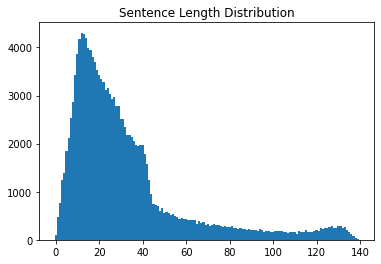

In [56]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

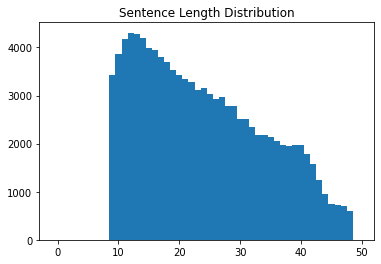

In [59]:
max_len = 50
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

# SentencePiece 모델 학습

In [49]:
import sentencepiece as spm

In [90]:
# 길이대로 자른 filtered_corpus를 사용하여 SentencePiece 적용
# 1. 리뷰 데이터를 파일로 저장
corpus_file = "nsmc_corpus.txt"
with open(corpus_file, 'w', encoding='utf-8') as f:
    for sentence in filtered_corpus:
        f.write(sentence + '\n')

# 2. SentencePiece 모델 학습
vocab_size = 32000  # 원하는 어휘 크기를 지정
spm.SentencePieceTrainer.Train(f'--input={corpus_file} --model_prefix=nsmc_spm --vocab_size={vocab_size} --model_type=bpe')

In [91]:
with open(corpus_file, 'r', encoding='utf-8') as f:
    line_count = sum(1 for line in f)  # 파일 내의 라인 수를 셉니다.

print(f"파일 내 문장의 개수: {line_count}개")

파일 내 문장의 개수: 106095개


In [92]:
# 3. 학습된 SentencePiece 모델 로드
sp = spm.SentencePieceProcessor()
sp.load('nsmc_spm.model')

# 4. sp_tokenize 함수를 적용하여 SentencePiece 토큰화 및 패딩 적용
def sp_tokenize(s, corpus):
    tensor = []

    # 문장을 정수 인덱스 시퀀스로 변환
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    # 학습된 SentencePiece 어휘 파일에서 단어-인덱스 매핑 생성
    with open("./nsmc_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        word_index.update({word: idx})
        index_word.update({idx: word})

    # 패딩 적용
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=max_len, padding='pre')

    return tensor, word_index, index_word

# 5. sp_tokenize 함수로 데이터 전처리 수행
padded_sequences, word_index, index_word = sp_tokenize(sp, filtered_corpus)

# 패딩된 데이터 확인 (상위 5개)
print(padded_sequences[:5])

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0  2018 22579    76 30611  1501  3895  1316
  31053 30639]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0  3970 30456
    564  1767]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0 16192
   5625  8610]
 [    0     0     0     0     0     0     0     0     0     0     0

In [93]:
# 단어-인덱스 맵핑 확인
print("단어 인덱스 맵핑:", word_index)
print("인덱스-단어 맵핑:", index_word)

단어 인덱스 맵핑: {'<unk>': 0, '<s>': 1, '</s>': 2, '영화': 3, '▁영화': 4, '▁이': 5, '▁아': 6, '▁재': 7, '▁보': 8, '▁그': 9, 'ᄏᄏ': 10, '▁정': 11, '너무': 12, '니다': 13, '▁나': 14, '▁좋': 15, '▁재미': 16, '는데': 17, '▁없': 18, '▁너무': 19, '▁다': 20, '▁진': 21, '▁감': 22, '▁최': 23, '▁내': 24, '▁어': 25, '▁하': 26, '▁지': 27, '▁시': 28, '▁정말': 29, '▁점': 30, '▁사': 31, '▁연': 32, '▁재밌': 33, '네요': 34, '▁만': 35, '▁한': 36, '지만': 37, '▁있': 38, '▁스': 39, '▁안': 40, '하고': 41, '▁가': 42, '▁봤': 43, '으로': 44, '▁기': 45, '▁평': 46, '▁진짜': 47, '▁최고': 48, '▁대': 49, '에서': 50, '▁전': 51, '어요': 52, '▁마': 53, '▁연기': 54, '▁무': 55, '▁여': 56, '▁ᄏᄏ': 57, '▁평점': 58, '▁수': 59, '▁잘': 60, '▁이런': 61, '▁모': 62, '하다': 63, '▁않': 64, '이다': 65, '▁더': 66, '▁주': 67, '하는': 68, '▁개': 69, '▁생': 70, '▁오': 71, '▁왜': 72, '▁제': 73, '드라': 74, '습니다': 75, '토리': 76, '▁말': 77, '드라마': 78, '▁감동': 79, '▁인': 80, '배우': 81, '▁유': 82, '▁본': 83, '▁볼': 84, '▁소': 85, '▁지루': 86, '▁보고': 87, '▁생각': 88, '▁미': 89, '▁별': 90, '▁못': 91, '▁재미있': 92, '▁알': 93, '▁스토리': 94, '▁자': 95, 'ᅲᅲ': 96, '

# sp_tokenize() 메소드 구현

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, GlobalMaxPooling1D, Dense

# 1. sp_tokenize 함수를 사용하여 이미 패딩된 시퀀스 데이터 가져오기
padded_sequences, word_index, index_word = sp_tokenize(sp, filtered_corpus)

# 2. EarlyStopping 추가
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 3. 모델 생성 (드롭아웃 제거)
vocab_size = 32000  # SentencePiece에서 설정한 어휘 크기
embedding_dim = 128
hidden_units = 128  # LSTM 유닛 수 설정

model = Sequential()
# 3-1. 임베딩 층
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
# 3-2. LSTM 층
model.add(LSTM(hidden_units, return_sequences=True))
# 3-3. GlobalMaxPooling1D 층 (가장 중요한 정보만 추출)
model.add(GlobalMaxPooling1D())
# 3-4. 최종 출력층 (이진 분류를 위한 시그모이드 활성화 함수)
model.add(Dense(1, activation='sigmoid'))
# 4. 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# 5. 모델 학습 (EarlyStopping 적용)
model.fit(padded_sequences, train_data['label'], 
          epochs=10, 
          batch_size=64, 
          validation_split=0.2, 
          callbacks=[early_stopping])

Epoch 1/10
1327/1327 [==============================] - 11s 7ms/step - loss: 0.6934 - accuracy: 0.4991 - val_loss: 0.6933 - val_accuracy: 0.5016
Epoch 2/10
1327/1327 [==============================] - 9s 7ms/step - loss: 0.6750 - accuracy: 0.5799 - val_loss: 0.7103 - val_accuracy: 0.4962
Epoch 3/10
1327/1327 [==============================] - 9s 7ms/step - loss: 0.5275 - accuracy: 0.7325 - val_loss: 0.8416 - val_accuracy: 0.4952
Epoch 4/10
1327/1327 [==============================] - 9s 7ms/step - loss: 0.2704 - accuracy: 0.8851 - val_loss: 1.1781 - val_accuracy: 0.4943


# 회고

SentencePiece같은 subword 기반 토크나이저를 사용하려니까 처음에 많이 헷갈렸음. 전처리는 어디까지 해야하는지 등...
<실험 결과>
1. accuracy 값 너무 안나와서 배치 사이즈를 늘려봤음 -> 성능 향상에 도움 안됨
2. 드롭아웃 제거하고 Earlystopping 적용 -> accuracy: 0.6514, val_accuracy: 0.4956...왜이러지?
3. 유닛 수 64에서 128로 증가, LSTM 층 추가(3개) -> accuracy: 0.6295, val_accuracy: 0.4945
4. Dense 레이어 추가 -> accuracy: 0.6270, val_accuracy: 0.4920
5. 패딩을 post 말고 pre로 적용 -> 위와 비슷하게 나옴
6. Bidirectional LSTM 제거, 유닛 수 64개 ->  accuracy: 0.6848, val_accuracy: 0.4966
7. GlobalMaxPooling1D 층 사용 -> accuracy: 0.7297, val_accuracy: 0.4920
8. vocab_size 8000에서 32000으로 증가 -> accuracy: 0.8851, val_accuracy: 0.4943
-> train 결과는 잘나오는데 왜 test 결과는 잘 안나오는걸까?
훈련 데이터와 테스트 데이터의 분포 차이가 있는걸까? 